In [26]:
# Imports
import numpy as np
import numpy.ma as ma
import sunpy.map
import sunpy.sun
from sunpy.map.maputils import all_coordinates_from_map
from sunpy.coordinates import get_horizons_coord
import glob
import boto3
from boto3 import session
session = boto3.session.Session(region_name='us-east-1')
s3client = session.client('s3')

def wavelet_enhancement(img):
    
    # https://www.harrisgeospatial.com/docs/Relational_Operators.html
    where_gt = np.where(img > 0.01)
    log_img = np.log10(img[where_gt])
    
    return

# Masking function
def mask_outside_disk(inst_map):
    # Find coordinates and radius
    hpc_coords = all_coordinates_from_map(inst_map)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / inst_map.rsun_obs
    
    # Mask everything outside of the solar disk
    mask = ma.masked_greater_equal(r, 1)
    ma.set_fill_value(mask, np.nan)
    where_disk = np.where(mask.mask == 1)
    
    return where_disk


def make_hist(norm_log_inst, bins_inst):
    
    where_mask = np.isfinite(norm_log_inst)
    arr = norm_log_inst[where_mask]
    hist, bins = np.histogram(arr, bins=bins_inst, density=True)
    width = bins[1] - bins[0]
    
    return hist*width


# Nb. of samples to use for the Hamada process
nb_samples = 95
nb_bins = 400
nb_channels = 3

# Find sample data
# Read
# npzfile = np.load('filenames_three_instruments_sync.npz')
npzfile = np.load('filenames_aligned.npz')
filenames_eit_0 = npzfile['filenames_eit_171'] 
filenames_eit_1 = npzfile['filenames_eit_195']
filenames_eit_2 = npzfile['filenames_eit_304'] 
filenames_euvil_0 = npzfile['filenames_euvil_171'] 
filenames_euvil_1 = npzfile['filenames_euvil_195'] 
filenames_euvil_2 = npzfile['filenames_euvil_304'] 

# Arrays for cdf
cdf_eit = np.zeros((nb_channels, nb_bins-1))
bins_eit = np.zeros((nb_channels, nb_bins))
cdf_euvil = np.zeros((nb_channels, nb_bins-1))
bins_euvil = np.zeros((nb_channels, nb_bins))

# Output
filename_output = 'cumulative_hist.npz'

# Loop over wavelengths
for channel_nb in range(nb_channels):
    
    if channel_nb == 0:
        filenames_eit = filenames_eit_0
        filenames_euvil = filenames_euvil_0
    elif channel_nb == 1:
        filenames_eit = filenames_eit_1
        filenames_euvil = filenames_euvil_1
    elif channel_nb == 2:
        filenames_eit = filenames_eit_2
        filenames_euvil = filenames_euvil_2
    
    # Map objects
    s3client.download_file('jh-tremblay', filenames_eit[0], 'eit-hamada.fits')
    eit_maps = sunpy.map.Map('eit-hamada.fits')  # [channel_nb, :])
    nx_eit, ny_eit = eit_maps.data.shape
    s3client.download_file('jh-tremblay', filenames_euvil[0], 'euvil-hamada.fits')
    euvil_maps = sunpy.map.Map('euvil-hamada.fits')  # [channel_nb, :])
    nx_euvil, ny_euvil = euvil_maps.data.shape
    print(filenames_eit[0], filenames_euvil[0])
    
    # Log arrays
    norm_log_eit = np.zeros((nb_samples, nx_eit, ny_eit))
    norm_log_euvil = np.zeros((nb_samples, nx_euvil, ny_euvil))

    # Histograms (of the standardized log intensities)
    hist_eit = np.zeros((nb_samples, nb_bins - 1))
    hist_euvil = np.zeros((nb_samples, nb_bins - 1))
    
    # File counter
    file_counter = 0
    
    # Loop over objects
    for file_nb in range(0, nb_samples):
        
        condition_positive = 0
        while(condition_positive == 0):
            s3client.download_file('jh-tremblay', filenames_eit[file_nb+file_counter], 'eit-hamada.fits')
            eit_maps = sunpy.map.Map('eit-hamada.fits')  # [channel_nb, :])
            nx_eit, ny_eit = eit_maps.data.shape
            s3client.download_file('jh-tremblay', filenames_euvil[file_nb+file_counter], 'euvil-hamada.fits')
            euvil_maps = sunpy.map.Map('euvil-hamada.fits')  # [channel_nb, :])
            nx_euvil, ny_euvil = euvil_maps.data.shape
        
            if eit_maps.observatory in ['SOHO']:
                new_coords = get_horizons_coord(eit_maps.observatory.replace(' ', '-'),
                                                eit_maps.date)
                eit_maps.meta['HGLN_OBS'] = new_coords.lon.to('deg').value
                eit_maps.meta['HGLT_OBS'] = new_coords.lat.to('deg').value
                eit_maps.meta['DSUN_OBS'] = new_coords.radius.to('m').value
                eit_maps.meta.pop('hec_x')
                eit_maps.meta.pop('hec_y')
                eit_maps.meta.pop('hec_z')
        
            # Mask everything outside of the solar disk
            # where_mask = mask_outside_disk(eit_maps[file_nb])
            hpc_coords = all_coordinates_from_map(eit_maps)
            r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / eit_maps.rsun_obs
            # Masking operation
            mask = ma.masked_greater_equal(r, 1)
            ma.set_fill_value(mask, np.nan)
            # Adjust data
            where_mask_eit = np.where(mask.mask == 1)
            eit_maps.data[where_mask_eit] = np.nan
            
            # Mask everything outside of the solar disk
            # where_mask = mask_outside_disk(euvil_maps[file_nb])
            hpc_coords = all_coordinates_from_map(euvil_maps)
            r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / euvil_maps.rsun_obs
            # Masking operation
            mask = ma.masked_greater_equal(r, 1)
            ma.set_fill_value(mask, np.nan)
            # Adjust data
            where_zeros = np.where(np.abs(euvil_maps.data) < 1.e-13 )
            euvil_maps.data[where_zeros] = 1.e-13
            where_mask_euvi = np.where(mask.mask == 1)
            euvil_maps.data[where_mask_euvi] = np.nan
            
            
            if(np.nanmin(eit_maps.data) > 0):
                condition_positive = 1
                print(channel_nb, file_nb, 'EIT (after masking)', np.nanmin(eit_maps.data), np.nanmax(eit_maps.data))
                print('EUVI (after masking)', np.nanmin(euvil_maps.data**2), np.nanmax(euvil_maps.data**2))
            else:
                file_counter = file_counter + 1

        # Benoit: Insert wavelet filter here for EIT and square data
        
        
        # Log intensities
        log_eit = np.log10(eit_maps.data)
        log_euvil = np.log10(euvil_maps.data**2)

        # Normalization
        mean_log_eit = np.nanmean(log_eit)
        std_log_eit = np.nanstd(log_eit)
        # print(channel_nb, file_nb, 'Norm', mean_log_eit, std_log_eit)
        mean_log_euvil = np.nanmean(log_euvil)
        std_log_euvil = np.nanstd(log_euvil)
        # print(channel_nb, file_nb, 'Norm', mean_log_euvil, std_log_euvil)
        norm_log_eit[file_nb, :, :] = (log_eit - mean_log_eit)/std_log_eit
        norm_log_euvil[file_nb, :, :] = (log_euvil - mean_log_euvil) / std_log_euvil
        
    # Compute histograms
    dmin = np.nanmin(norm_log_eit)
    dmax = np.nanmax(norm_log_eit)
    bins_eit[channel_nb, :] = np.linspace(dmin, dmax, nb_bins)
    # print(channel_nb, file_nb, 'dmin', dmin, dmax)
    dmin = np.nanmin(norm_log_euvil)
    dmax = np.nanmax(norm_log_euvil)
    bins_euvil[channel_nb, :] = np.linspace(dmin, dmax, nb_bins)
    # print(channel_nb, file_nb, 'dmin', dmin, dmax)
    
    # Individual histograms
    for file_nb in range(nb_samples):
        # EIT
        hist_eit[file_nb, :] = make_hist(norm_log_eit[file_nb, :, :], bins_eit[channel_nb, :])
        # EUVI-l
        hist_euvil[file_nb, :] = make_hist(norm_log_euvil[file_nb, :, :], bins_euvil[channel_nb, :])

    # Average
    hist_eit = np.mean(hist_eit, axis=0)
    hist_euvil = np.mean(hist_euvil, axis=0)
    
    # Cumulative
    cdf_eit[channel_nb, :] = np.cumsum(hist_eit)
    cdf_euvil[channel_nb, :] = np.cumsum(hist_euvil)
    

#############
# End of file
#############

171/eit_l1_20070601_120014.fits 171_B/20070601_120100_171eu_L.fts
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 0 EIT (after masking) 28.86477841353158 1886.3114422606598
EUVI (after masking) 5.684342e-12 22.103533
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 1 EIT (after masking) 33.7853518431951 2439.9246515952345
EUVI (after masking) 8.4605745e-10 24.725006
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 2 EIT (after masking) 26.019357828106326 1586.9895839996336
EUVI (after masking) 7.258336e-10 20.086864
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 3 EIT (after masking) 26.165531195897216 8925.763430544946
EUVI (after masking) 1.9877575e-09 19.46883
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 4 EIT (after masking) 24.008324842799887 4545.746161676667
EUVI (after masking) 5.392394e-09 22.396729
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 5 EIT (after masking) 24.622895690135703 6972.337400214008
EUVI (after masking) 1.2238161e-08 13.90653
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 6 EIT (after masking) 27.24808418882617 2323.804143046438
EUVI (after masking) 1.1054965e-08 21.467731
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 7 EIT (after masking) 27.922807449745946 676.4758795931839
EUVI (after masking) 1.7635614e-08 17.541695
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 8 EIT (after masking) 27.40892958874603 2303.918454575812
EUVI (after masking) 1.5663773e-09 18.855507
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 9 EIT (after masking) 19.9537519086501 8511.079127575358
EUVI (after masking) 9.094947e-11 26.913906
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 10 EIT (after masking) 21.236018612407648 2242.0423927687093
EUVI (after masking) 4.604317e-12 17.692966
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 11 EIT (after masking) 26.413727557643185 1493.9181650441114
EUVI (after masking) 1.4210855e-12 23.986483
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 12 EIT (after masking) 21.00282124609114 1797.9443624612732
EUVI (after masking) 1.945466e-09 24.962997
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 13 EIT (after masking) 21.09780256996941 1819.1760288034027
EUVI (after masking) 4.9133178e-09 76.85347
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 14 EIT (after masking) 20.72849243593277 6442.983011369615
EUVI (after masking) 1.4551915e-11 15.472177
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 15 EIT (after masking) 23.518279526954483 1294.3831093262831
EUVI (after masking) 1.145969e-08 25.941164
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 16 EIT (after masking) 26.448841982939307 2197.3523187968085
EUVI (after masking) 2.2851196e-07 17.694748
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 17 EIT (after masking) 27.866360281271362 1739.9734163522414
EUVI (after masking) 5.4274665e-09 14.176671
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 18 EIT (after masking) 22.225814297997413 4046.4311053325787
EUVI (after masking) 6.963319e-11 23.425486
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 19 EIT (after masking) 27.60351470060816 1879.7852143763987
EUVI (after masking) 3.0358484e-07 20.433762
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 20 EIT (after masking) 28.707306260580502 982.9918770903074
EUVI (after masking) 5.6045337e-09 20.59175
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 21 EIT (after masking) 22.66833860572316 773.5586321463323
EUVI (after masking) 7.163692e-09 20.403652
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 22 EIT (after masking) 27.373068222727042 11967.366072150044
EUVI (after masking) 3.961759e-09 14.163458
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 23 EIT (after masking) 26.07872378315395 2185.2400465148016
EUVI (after masking) 1.519362e-08 17.255627
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 24 EIT (after masking) 29.118616219719407 5764.350885097625
EUVI (after masking) 5.6761564e-09 18.167303
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 25 EIT (after masking) 22.63553272060957 1003.5868007925892
EUVI (after masking) 4.9587698e-08 14.68654
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 26 EIT (after masking) 24.684658587910604 4617.617543246276
EUVI (after masking) 6.227822e-09 17.5651
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 27 EIT (after masking) 20.843123661737295 1385.6615122227174
EUVI (after masking) 5.9139893e-10 17.531132
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 28 EIT (after masking) 17.256208387433112 1160.703493906526
EUVI (after masking) 1.0359713e-09 14.092047
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 29 EIT (after masking) 19.503579536122473 1811.3594346658128
EUVI (after masking) 1.5288606e-09 20.01391
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 30 EIT (after masking) 23.341736421432326 1216.5221247614243
EUVI (after masking) 2.5211398e-07 19.80743
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 31 EIT (after masking) 20.265543044080786 1500.8495194188854
EUVI (after masking) 3.541354e-07 18.057287
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 32 EIT (after masking) 19.325881635617126 3531.636939110962
EUVI (after masking) 8.599841e-10 18.164906
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 33 EIT (after masking) 16.605865024021867 1240.0044706024505
EUVI (after masking) 7.1304385e-10 32.033455
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 34 EIT (after masking) 20.07099333463378 988.7962344582742
EUVI (after masking) 6.148184e-10 16.130537
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 35 EIT (after masking) 19.444332638052312 1244.7101377865195
EUVI (after masking) 9.369842e-09 21.348198
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 36 EIT (after masking) 20.425895268348597 1217.1859435112337
EUVI (after masking) 3.4583536e-10 17.700686
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 37 EIT (after masking) 21.312144991093525 848.8257111500045
EUVI (after masking) 1.6822014e-08 13.758061
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 38 EIT (after masking) 24.190001243037848 1177.554944849831
EUVI (after masking) 1.8468427e-10 48.307415
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 39 EIT (after masking) 22.165210963631292 1793.6894790199483
EUVI (after masking) 1.07625965e-07 14.521696
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 40 EIT (after masking) 23.452486652237944 12842.813321518153
EUVI (after masking) 1.945466e-09 14.397086
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 41 EIT (after masking) 24.425847109029938 795.3966662624327
EUVI (after masking) 2.0520474e-11 21.023983
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 42 EIT (after masking) 22.984297365830876 771.4808582494563
EUVI (after masking) 2.2127603e-07 16.565052
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 43 EIT (after masking) 25.344862770409485 6937.291129629037
EUVI (after masking) 1.0982717e-09 14.387612
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 44 EIT (after masking) 24.15008003416392 1130.8411802132619
EUVI (after masking) 1.4210855e-08 33.961006
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 45 EIT (after masking) 22.210504077129798 3965.982495688265
EUVI (after masking) 9.602047e-09 23.902802
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 46 EIT (after masking) 21.998602743815287 7228.403797703604
EUVI (after masking) 3.379006e-08 18.720293
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 47 EIT (after masking) 25.150963984992767 1260.1033677884154
EUVI (after masking) 3.5527137e-11 18.51198
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 48 EIT (after masking) 24.40352102155388 1477.7421315510308
EUVI (after masking) 1.6209242e-08 21.258102
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 49 EIT (after masking) 19.887694637549355 1632.4362883600095
EUVI (after masking) 8.782587e-08 22.244232
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 50 EIT (after masking) 23.515757612988917 1283.6365056795971
EUVI (after masking) 1.5475621e-09 17.813627
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 51 EIT (after masking) 24.22969071235642 3653.390930771835
EUVI (after masking) 8.645884e-11 35.805553
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 52 EIT (after masking) 22.329623726242865 1800.4274370413273
EUVI (after masking) 1.4267755e-08 17.909847
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 53 EIT (after masking) 26.371090680647335 876.4884057657745
EUVI (after masking) 1.0825261e-09 19.265757
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 54 EIT (after masking) 22.996257152088823 1507.2134861434197
EUVI (after masking) 1.7195134e-10 20.903406
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 55 EIT (after masking) 21.325533853771674 2522.013537887017
EUVI (after masking) 3.414158e-08 17.04641
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 56 EIT (after masking) 22.429778750932492 1232.1520885872837
EUVI (after masking) 9.904397e-10 20.691942
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 57 EIT (after masking) 21.24063673880512 792.3973503778668
EUVI (after masking) 1.9015494e-07 14.414227
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 58 EIT (after masking) 20.52547448913679 1738.1615864921375
EUVI (after masking) 1.0715718e-07 14.86693
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 59 EIT (after masking) 19.098065883148625 1840.3682461643402
EUVI (after masking) 5.3483973e-08 14.174124
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 60 EIT (after masking) 20.612313064021055 1156.3225127677201
EUVI (after masking) 8.599841e-10 18.33845
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 61 EIT (after masking) 25.903317904555486 2817.962522030218
EUVI (after masking) 3.5243488e-09 16.494152
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 62 EIT (after masking) 24.000692503144034 1408.6827377495754
EUVI (after masking) 7.7812956e-10 17.306911
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 63 EIT (after masking) 22.483587010970524 8766.20207085042
EUVI (after masking) 2.5067948e-09 23.081173
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 64 EIT (after masking) 24.57658064563412 1091.4709817320206
EUVI (after masking) 1.7826096e-10 15.040255
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 65 EIT (after masking) 25.68241504442379 7325.121046716627
EUVI (after masking) 2.2346796e-08 15.548432
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 66 EIT (after masking) 22.946561297253314 3060.734446666104
EUVI (after masking) 4.7072035e-10 20.44327
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 67 EIT (after masking) 30.958738981150642 2336.5969486459903
EUVI (after masking) 5.568893e-09 23.158367
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 68 EIT (after masking) 32.06598092755096 11586.998453812133
EUVI (after masking) 9.1538425e-08 22.065048
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 69 EIT (after masking) 28.43825747830451 3502.734712141058
EUVI (after masking) 3.6384904e-09 21.047047
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 70 EIT (after masking) 26.908214096164016 3347.8051260051707
EUVI (after masking) 7.3356205e-08 15.198711
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 71 EIT (after masking) 31.018834845980024 5016.012425406712
EUVI (after masking) 3.9318024e-09 22.802288
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 72 EIT (after masking) 31.09842346578305 1362.8695089535222
EUVI (after masking) 6.1527885e-09 18.788153
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 73 EIT (after masking) 34.842380800366804 5879.975913058194
EUVI (after masking) 8.4328576e-08 20.364712
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 74 EIT (after masking) 24.437822311755426 1768.6198651554168
EUVI (after masking) 9.049529e-09 13.9312525
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 75 EIT (after masking) 32.31150994257718 3335.616666879092
EUVI (after masking) 5.893753e-09 22.684002
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 76 EIT (after masking) 25.914316975018554 4351.629806566466
EUVI (after masking) 1.6427748e-11 69.60733
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 77 EIT (after masking) 30.281679070948517 1530.605011985861
EUVI (after masking) 5.798597e-08 19.602661
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 78 EIT (after masking) 28.673089764001073 6389.066944374213
EUVI (after masking) 3.121164e-08 18.336807
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 79 EIT (after masking) 31.034502731811013 3947.4419903683192
EUVI (after masking) 5.5712235e-10 23.368368
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 80 EIT (after masking) 29.658700574232487 1559.67948266134
EUVI (after masking) 4.4521187e-08 13.72927
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 81 EIT (after masking) 20.290629730199036 1820.1447671034393
EUVI (after masking) 9.024461e-10 16.986692
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 82 EIT (after masking) 23.029694044529215 643.5075105910644
EUVI (after masking) 1.7408297e-09 15.787096
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 83 EIT (after masking) 21.980731642852977 5647.187782430722
EUVI (after masking) 1.6575541e-08 19.082333
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 84 EIT (after masking) 20.125096266591747 1167.3059913496675
EUVI (after masking) 5.0376566e-06 19.367382
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 85 EIT (after masking) 23.001903433226545 1289.044865087076
EUVI (after masking) 6.4909837e-06 14.799531
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 86 EIT (after masking) 27.283695193944684 2744.5762274374133
EUVI (after masking) 1.2412856e-06 21.561758
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 87 EIT (after masking) 24.111330046343074 1872.6509697162458
EUVI (after masking) 8.036295e-09 24.664694
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 88 EIT (after masking) 22.628990720010208 4039.014498825923
EUVI (after masking) 4.6495643e-09 20.62731
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 89 EIT (after masking) 21.92339609450146 2594.9628306592535
EUVI (after masking) 4.2520156e-07 15.986293
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 90 EIT (after masking) 26.680138515063057 4077.4570692592965
EUVI (after masking) 2.9467628e-08 14.668616
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 91 EIT (after masking) 26.42576566937337 1245.240814897962
EUVI (after masking) 4.8466973e-09 13.234909
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 92 EIT (after masking) 28.841885484325573 1034.7099681677703
EUVI (after masking) 4.906635e-07 18.11635
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 93 EIT (after masking) 25.04150620034328 1652.5548811522883
EUVI (after masking) 1.0422539e-06 17.713848
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


0 94 EIT (after masking) 27.261235697835655 1208.24907740003
EUVI (after masking) 2.2604147e-06 20.085001
195/eit_l1_20070601_121346.fits 195_B/20070601_120530_195eu_L.fts
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 0 EIT (after masking) 7.582954804997231 1806.549607173933
EUVI (after masking) 9.094947e-13 22.723864
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 1 EIT (after masking) 6.897907950598854 6194.894849707818
EUVI (after masking) 1.9122126e-10 49.82327
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 2 EIT (after masking) 9.486792064752139 3453.3368096268086
EUVI (after masking) 1.82132e-09 25.241741
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 3 EIT (after masking) 6.161138089089426 1782.1252838945927
EUVI (after masking) 1.4734383e-07 203.33476
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 4 EIT (after masking) 4.7743039525243836 1588.4787249435635
EUVI (after masking) 3.637979e-12 41.82556
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 5 EIT (after masking) 3.6432046902942674 7035.943168322664
EUVI (after masking) 4.604317e-12 31.326784
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 6 EIT (after masking) 4.477465263305371 14432.425245786384
EUVI (after masking) 2.3283064e-10 28.729034
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 7 EIT (after masking) 6.2511848663592895 5525.8694543189795
EUVI (after masking) 5.684342e-12 44.45847
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 8 EIT (after masking) 7.936438936348309 915.5702758740332
EUVI (after masking) 1.3306476e-09 34.466404
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 9 EIT (after masking) 3.245709467049495 2216.908707262069
EUVI (after masking) 1.4210855e-12 36.4268
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 10 EIT (after masking) 3.4675968784484454 2477.077482209184
EUVI (after masking) 5.684342e-14 33.346874
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 11 EIT (after masking) 8.480179268681775 5160.999245980239
EUVI (after masking) 8.185452e-12 26.20896
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 12 EIT (after masking) 4.418782467956085 3476.1866914853517
EUVI (after masking) 8.645884e-11 31.172085
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 13 EIT (after masking) 4.224242520644951 2626.6637311631152
EUVI (after masking) 2.7853275e-12 29.965605
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 14 EIT (after masking) 3.6672513338368478 1908.6258488984822
EUVI (after masking) 4.7805315e-11 31.05337
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 15 EIT (after masking) 4.093821966542013 12889.220767680017
EUVI (after masking) 1.114131e-11 29.334919
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 16 EIT (after masking) 4.2038415864836285 1277.3465279333154
EUVI (after masking) 2.046363e-12 28.046055
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 17 EIT (after masking) 4.728981325527331 1012.0665385177796
EUVI (after masking) 3.842615e-11 199.8665
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 18 EIT (after masking) 5.183247440515072 2604.1624484029417
EUVI (after masking) 8.20819e-11 25.694334
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 19 EIT (after masking) 8.682758322106372 3266.559763613689
EUVI (after masking) 2.046363e-12 50.77772
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 20 EIT (after masking) 5.3587708777465615 5212.286929730473
EUVI (after masking) 3.842615e-11 36.622074
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 21 EIT (after masking) 5.56573445195393 2238.25778955996
EUVI (after masking) 2.046363e-12 25.9756
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 22 EIT (after masking) 5.423201539027154 1176.587139430924
EUVI (after masking) 2.046363e-12 29.13207
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 23 EIT (after masking) 3.0936913125086045 1597.1886507844508
EUVI (after masking) 3.274181e-11 66.71905
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 24 EIT (after masking) 4.776692861927617 2669.76734794561
EUVI (after masking) 4.604317e-12 36.91245
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 25 EIT (after masking) 4.061189839551125 1097.47319975315
EUVI (after masking) 5.684342e-14 26.815857
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 26 EIT (after masking) 9.880717216425627 10435.333107177985
EUVI (after masking) 2.0520474e-11 33.1174
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 27 EIT (after masking) 5.046663842352339 2142.5383387468587
EUVI (after masking) 8.20819e-11 24.520615
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 28 EIT (after masking) 4.147369566829851 1379.647250862122
EUVI (after masking) 4.456524e-11 30.50594
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 29 EIT (after masking) 0.8347039854209021 1330.5105784488437
EUVI (after masking) 9.555379e-11 30.11181
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 30 EIT (after masking) 2.2674923942313 1598.75788915308
EUVI (after masking) 1.4210855e-12 49.75471
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 31 EIT (after masking) 1.5851613014791834 21366.94200394669
EUVI (after masking) 9.094947e-13 27.789764
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 32 EIT (after masking) 2.691417609100914 1755.59227754366
EUVI (after masking) 1.4210855e-12 29.190208
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 33 EIT (after masking) 6.708554037218189 7795.067434385692
EUVI (after masking) 6.266987e-10 55.92252
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 34 EIT (after masking) 5.918329920887243 1614.1505133130927
EUVI (after masking) 8.185452e-12 30.782043
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 35 EIT (after masking) 0.4012476150157477 1129.8276242759482
EUVI (after masking) 8.20819e-11 24.938978
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 36 EIT (after masking) 1.1314475285078212 2941.2002170005144
EUVI (after masking) 2.8654767e-10 66.51122
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 37 EIT (after masking) 1.2116711388867922 2601.65868941757
EUVI (after masking) 2.5067948e-11 25.871393
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 38 EIT (after masking) 4.087063457568851 1123.7980770407707
EUVI (after masking) 6.190248e-11 38.831387
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 39 EIT (after masking) 2.957498876112445 2207.6184253944416
EUVI (after masking) 5.684342e-12 31.012001
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 40 EIT (after masking) 3.6042064015394653 3144.3183334313467
EUVI (after masking) 2.4760993e-10 27.307007
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 41 EIT (after masking) 4.1211468572062975 2434.730570720761
EUVI (after masking) 2.7512215e-11 38.69124
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 42 EIT (after masking) 4.900141249188143 2565.5091822579393
EUVI (after masking) 2.7512215e-11 29.350128
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 43 EIT (after masking) 4.807317259993435 1444.0204292723497
EUVI (after masking) 1.537046e-10 31.396255
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 44 EIT (after masking) 4.585942443435182 2653.3435265422463
EUVI (after masking) 5.684342e-14 27.689869
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 45 EIT (after masking) 6.788902759692265 13854.274168210932
EUVI (after masking) 1.4210855e-12 26.299488
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 46 EIT (after masking) 3.9143311822905638 2146.8135595015865
EUVI (after masking) 1.4551915e-11 71.814766
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 47 EIT (after masking) 5.234814464197525 5441.363906715059
EUVI (after masking) 1.2789769e-11 27.648489
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 48 EIT (after masking) 4.239303052709271 2262.7972947147696
EUVI (after masking) 2.2737368e-13 26.387554
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 49 EIT (after masking) 6.717759138263735 5271.038897130951
EUVI (after masking) 2.2737368e-13 42.28477
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 50 EIT (after masking) 5.43809210978764 12131.125089108142
EUVI (after masking) 5.684342e-14 38.62245
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 51 EIT (after masking) 5.0666873439907185 7859.767164728538
EUVI (after masking) 3.842615e-11 27.036863
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 52 EIT (after masking) 6.324996393284861 3684.8491752054174
EUVI (after masking) 9.555379e-11 26.419834
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 53 EIT (after masking) 6.257902477644161 9226.516921475293
EUVI (after masking) 4.604317e-12 36.694736
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 54 EIT (after masking) 4.905804760437073 2003.1176505857927
EUVI (after masking) 6.8780537e-12 25.66221
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 55 EIT (after masking) 6.029743778888959 2209.6454278769907
EUVI (after masking) 2.046363e-12 27.790266
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 56 EIT (after masking) 6.275688792986409 4992.175560411153
EUVI (after masking) 2.046363e-12 46.966972
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 57 EIT (after masking) 5.122458184140022 8110.324398114237
EUVI (after masking) 3.5527137e-11 25.696383
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 58 EIT (after masking) 5.825760859033996 1362.3169070673728
EUVI (after masking) 1.4551915e-11 44.137554
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 59 EIT (after masking) 5.3576529503886565 3166.493832530736
EUVI (after masking) 2.0520474e-11 29.86646
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 60 EIT (after masking) 4.691561971210095 1051.8940713720126
EUVI (after masking) 3.637979e-12 28.027826
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 61 EIT (after masking) 4.2928781740389566 2502.651318979547
EUVI (after masking) 6.8780537e-12 23.518785
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 62 EIT (after masking) 3.7108553883949766 9748.925129840882
EUVI (after masking) 1.5967316e-10 31.129929
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 63 EIT (after masking) 4.78078505459415 2185.512809020223
EUVI (after masking) 2.2737368e-13 33.95825
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 64 EIT (after masking) 4.570380089397038 6526.747810926705
EUVI (after masking) 3.1974423e-10 28.185638
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 65 EIT (after masking) 5.207231163539775 2234.941051152263
EUVI (after masking) 3.1974423e-10 32.11199
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 66 EIT (after masking) 3.2527077940480615 1154.3666271692816
EUVI (after masking) 1.1461907e-09 35.260315
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 67 EIT (after masking) 5.282188587963865 19392.536382413145
EUVI (after masking) 2.2737368e-13 24.60346
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 68 EIT (after masking) 4.200111520271752 2964.997931747095
EUVI (after masking) 4.7072035e-10 24.524317
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 69 EIT (after masking) 1.2240597990882935 1854.8217870041592
EUVI (after masking) 3.637979e-12 29.664978
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 70 EIT (after masking) 7.915386614321704 4474.846660875608
EUVI (after masking) 1.8417268e-11 31.917091
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 71 EIT (after masking) 7.976858260305747 4150.447792153666
EUVI (after masking) 4.7805315e-11 22.495886
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 72 EIT (after masking) 7.496711979869706 6710.2768976094
EUVI (after masking) 5.1159077e-11 27.161175
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 73 EIT (after masking) 6.450279384884458 2105.761222083067
EUVI (after masking) 1.0027179e-10 33.52145
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 74 EIT (after masking) 7.586244601628706 12070.869722995585
EUVI (after masking) 2.185061e-10 30.417807
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 75 EIT (after masking) 6.035487117663698 3182.8214865581795
EUVI (after masking) 5.684342e-12 26.468714
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 76 EIT (after masking) 8.34698591414055 16647.159096487434
EUVI (after masking) 4.456524e-11 32.04633
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 77 EIT (after masking) 8.149092991891374 14070.238241195164
EUVI (after masking) 5.4626526e-11 26.219257
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 78 EIT (after masking) 7.838412929083578 9383.912129304548
EUVI (after masking) 9.555379e-11 44.423504
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 79 EIT (after masking) 4.569564091205196 2194.191797257124
EUVI (after masking) 2.2737368e-11 31.174332
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 80 EIT (after masking) 4.197098563890055 11023.425109686075
EUVI (after masking) 1.6427748e-11 31.372044
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 81 EIT (after masking) 4.7413900675992995 1472.5384523424864
EUVI (after masking) 1.4551915e-11 23.850018
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 82 EIT (after masking) 5.9725962064526525 4436.815412274068
EUVI (after masking) 5.1159077e-13 29.779928
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 83 EIT (after masking) 7.302987236614293 15674.770558555989
EUVI (after masking) 2.7512215e-11 27.458588
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 84 EIT (after masking) 1.8130640153697537 1387.2322558334088
EUVI (after masking) 6.571099e-11 113.56867
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 85 EIT (after masking) 4.820137576324459 11606.260482883445
EUVI (after masking) 1e-26 32.07549
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 86 EIT (after masking) 4.912184579251449 1206.3761242198548
EUVI (after masking) 2.7512215e-11 40.545704
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 87 EIT (after masking) 5.0794002966642955 1175.892278994885
EUVI (after masking) 1.4210855e-12 34.293518
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 88 EIT (after masking) 6.733251061283192 1884.436310461237
EUVI (after masking) 4.2041393e-10 25.219198
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 89 EIT (after masking) 4.8721393154620065 10007.811172948024
EUVI (after masking) 7.366907e-11 31.7349
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 90 EIT (after masking) 5.119334804943971 3832.6863419957394
EUVI (after masking) 7.366907e-11 27.454239
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 91 EIT (after masking) 6.452570499185659 1878.8529781268028
EUVI (after masking) 3.637979e-12 29.700674
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 92 EIT (after masking) 7.336833076368272 3277.820857421404
EUVI (after masking) 1.3096724e-10 29.980324
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 93 EIT (after masking) 7.1870555883905105 8799.85882746491
EUVI (after masking) 1e-26 29.614532
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


1 94 EIT (after masking) 2.665235405342157 1035.389336809084
EUVI (after masking) 8.645884e-11 37.622116
304/eit_l1_20070601_121937.fits 304_B/20070601_120615_304eu_L.fts
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 0 EIT (after masking) 13.949438335185118 1498.6047041658603
EUVI (after masking) 8.036295e-09 28.49914
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 1 EIT (after masking) 13.47750713693878 1931.070032699615
EUVI (after masking) 4.0827217e-09 40.487362
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 2 EIT (after masking) 15.988451246774114 2017.3222552650743
EUVI (after masking) 3.3702463e-08 27.809862
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 3 EIT (after masking) 9.710816785673801 6109.506156180132
EUVI (after masking) 1.11095005e-07 308.4729
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 4 EIT (after masking) 11.482812179139724 1153.7867955458876
EUVI (after masking) 1.3426188e-08 26.425186
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 5 EIT (after masking) 6.524242395987141 1795.2871729528629
EUVI (after masking) 3.0332217e-07 24.479721
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 6 EIT (after masking) 11.706873889937123 1695.2539756649253
EUVI (after masking) 1.6738431e-07 25.330805
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 7 EIT (after masking) 9.798778577308813 2731.9048866670296
EUVI (after masking) 2.6439238e-08 32.53339
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 8 EIT (after masking) 10.799166975568225 4688.274323489554
EUVI (after masking) 9.004225e-09 29.290897
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 9 EIT (after masking) 10.498626650536375 5578.10659917903
EUVI (after masking) 4.087633e-08 34.39199
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 10 EIT (after masking) 11.370643379353767 5928.461153943941
EUVI (after masking) 1.6575541e-10 23.815863
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 11 EIT (after masking) 12.643428589164513 5194.877399251321
EUVI (after masking) 8.995835e-08 42.622746
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 12 EIT (after masking) 13.077869507971155 3809.6630851970976
EUVI (after masking) 3.328978e-09 23.95238
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 13 EIT (after masking) 12.217229596261873 1375.6234601149736
EUVI (after masking) 7.614517e-09 26.419554
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 14 EIT (after masking) 11.651104181255272 1242.7718374309918
EUVI (after masking) 3.0070169e-09 25.430424
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 15 EIT (after masking) 12.549760010553861 5184.105292882913
EUVI (after masking) 1.1787051e-09 31.525711
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 16 EIT (after masking) 11.663543219465748 1661.9086414953913
EUVI (after masking) 7.622498e-08 38.065872
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 17 EIT (after masking) 12.438001118215524 2566.0460012251037
EUVI (after masking) 8.740244e-08 27.893072
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 18 EIT (after masking) 11.706386574446718 5888.42682167808
EUVI (after masking) 1.537046e-10 29.113815
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 19 EIT (after masking) 12.948429600220589 2544.7853385046533
EUVI (after masking) 8.645884e-09 31.374361
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 20 EIT (after masking) 6.0431984244318775 1814.4814704637465
EUVI (after masking) 2.199181e-08 26.055008
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 21 EIT (after masking) 10.192910063171551 2373.441962875961
EUVI (after masking) 5.2386895e-10 25.460793
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 22 EIT (after masking) 13.185616734835577 1711.83537005835
EUVI (after masking) 1.9386789e-08 84.88727
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 23 EIT (after masking) 11.782314413807851 796.3597153001281
EUVI (after masking) 1.9653271e-08 31.962107
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 24 EIT (after masking) 12.416524082605 2026.7383113465262
EUVI (after masking) 1.3426188e-08 25.739378
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 25 EIT (after masking) 7.80685068924849 1587.994040782773
EUVI (after masking) 7.9148776e-10 29.085377
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 26 EIT (after masking) 12.812690025920496 2209.0255661955816
EUVI (after masking) 1.572721e-08 24.376034
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 27 EIT (after masking) 12.608191239011912 5626.520295917648
EUVI (after masking) 7.0542455e-08 27.357822
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 28 EIT (after masking) 12.026749272643132 1426.5937471951058
EUVI (after masking) 5.184347e-09 27.206587
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 29 EIT (after masking) 9.839226978288053 1595.938406328459
EUVI (after masking) 2.4760993e-10 30.043139
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 30 EIT (after masking) 10.40788332407483 2434.725585560208
EUVI (after masking) 2.4122073e-09 26.214203
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 31 EIT (after masking) 10.678081455449393 623.2731138810475
EUVI (after masking) 8.469442e-09 26.86741
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 32 EIT (after masking) 9.769396516669492 1721.8055738428181
EUVI (after masking) 2.2737368e-11 23.421474
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 33 EIT (after masking) 11.323498443940865 692.6462903786055
EUVI (after masking) 3.5475978e-08 27.947878
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 34 EIT (after masking) 10.796905918922636 4244.1908174471955
EUVI (after masking) 6.4173946e-09 33.5367
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 35 EIT (after masking) 12.415758662510108 5199.520416040541
EUVI (after masking) 6.8780537e-10 38.614838
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 36 EIT (after masking) 13.29554937662927 2378.576148828109
EUVI (after masking) 1.4917987e-09 35.25593
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 37 EIT (after masking) 12.015581046076035 2939.2992779114743
EUVI (after masking) 2.4760993e-08 31.399536
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 38 EIT (after masking) 9.834454473216237 4571.439233857667
EUVI (after masking) 1.7070306e-08 24.933168
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 39 EIT (after masking) 8.986527923819633 6373.191117528711
EUVI (after masking) 2.0090738e-09 28.581528
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 40 EIT (after masking) 13.01221185220159 934.8534854418787
EUVI (after masking) 2.9467628e-10 23.529377
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 41 EIT (after masking) 12.025371501663676 2317.3123946247056
EUVI (after masking) 3.274181e-09 24.92915
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 42 EIT (after masking) 11.143329119355673 1342.9987788767783
EUVI (after masking) 1.7728075e-07 37.22718
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 43 EIT (after masking) 11.878124888025976 882.4325352410198
EUVI (after masking) 3.4761115e-08 24.858437
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 44 EIT (after masking) 12.914179410819127 2461.098723326807
EUVI (after masking) 8.185452e-12 25.16609
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 45 EIT (after masking) 11.048081544856943 1264.516636274139
EUVI (after masking) 6.6486336e-09 50.569958
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 46 EIT (after masking) 10.97785223505313 1191.2971442072828
EUVI (after masking) 1.8468427e-08 27.384657
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 47 EIT (after masking) 11.969232376153883 721.6666810322371
EUVI (after masking) 4.1262865e-08 36.757416
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 48 EIT (after masking) 11.615061915222384 6837.541601091572
EUVI (after masking) 2.0327434e-08 30.595844
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 49 EIT (after masking) 12.983050095135894 1859.0890198674133
EUVI (after masking) 1.8081664e-08 23.838552
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 50 EIT (after masking) 10.991401728433237 2578.763987721435
EUVI (after masking) 3.4960976e-09 27.61834
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 51 EIT (after masking) 12.152265716583917 1735.8606214118736
EUVI (after masking) 9.3715244e-08 44.164036
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 52 EIT (after masking) 12.483688829661908 4467.194518390689
EUVI (after masking) 7.2041075e-09 30.273283
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 53 EIT (after masking) 11.919197848359369 1870.47022221446
EUVI (after masking) 4.022013e-09 30.01687
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 54 EIT (after masking) 11.60651359232651 2923.959553526858
EUVI (after masking) 8.543998e-08 24.270617
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 55 EIT (after masking) 9.42157615010739 4002.162806938917
EUVI (after masking) 8.20819e-11 27.752176
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 56 EIT (after masking) 13.606053952676685 2054.575333596837
EUVI (after masking) 7.9148776e-10 25.553288
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 57 EIT (after masking) 11.991573229596424 6424.575191646609
EUVI (after masking) 4.0108716e-10 29.242828
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 58 EIT (after masking) 12.532678295224333 5604.030173013081
EUVI (after masking) 3.283276e-10 38.022346
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 59 EIT (after masking) 11.726218568782906 5757.401353306618
EUVI (after masking) 7.366907e-11 36.375526
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 60 EIT (after masking) 11.878750026711227 3557.468529860537
EUVI (after masking) 1.0027179e-10 27.87671
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 61 EIT (after masking) 11.461463132443916 4022.025292951503
EUVI (after masking) 3.637979e-12 30.628935
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 62 EIT (after masking) 11.30121141442086 7917.9431161774555
EUVI (after masking) 9.094947e-13 30.10485
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 63 EIT (after masking) 10.722365932837452 1697.7256413105124
EUVI (after masking) 9.742735e-09 26.659456
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 64 EIT (after masking) 11.90841349837981 6251.997377695397
EUVI (after masking) 2.9033345e-09 26.492712
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 65 EIT (after masking) 13.748286820815922 2448.528323724438
EUVI (after masking) 3.0126103e-08 27.22334
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 66 EIT (after masking) 12.997929276274304 7774.399602970235
EUVI (after masking) 2.185061e-08 29.942999
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 67 EIT (after masking) 14.411014582469631 5441.046956807507
EUVI (after masking) 1.6043487e-07 35.296375
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 68 EIT (after masking) 14.288153968641893 8318.82763490597
EUVI (after masking) 1.7826096e-10 27.617933
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 69 EIT (after masking) 12.804061863940577 1036.1322876016577
EUVI (after masking) 4.165122e-08 24.628584
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 70 EIT (after masking) 14.724574582187483 2616.94188125246
EUVI (after masking) 1.4097395e-08 26.966276
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 71 EIT (after masking) 13.582895898657018 2398.9953264223127
EUVI (after masking) 7.531526e-09 25.140396
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 72 EIT (after masking) 12.940310032688718 3283.47678807174
EUVI (after masking) 1.2028067e-10 28.110668
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 73 EIT (after masking) 13.22780523378132 4310.353609098298
EUVI (after masking) 1.6816557e-09 22.500858
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 74 EIT (after masking) 12.69160154807142 1475.2284903176264
EUVI (after masking) 9.837095e-09 31.640057
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 75 EIT (after masking) 14.664584388256651 1167.6296169557813
EUVI (after masking) 2.046363e-12 25.995983
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 76 EIT (after masking) 12.988493784135072 1815.2286477009318
EUVI (after masking) 2.5364898e-08 30.563564
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 77 EIT (after masking) 12.658557543263173 1467.954628912931
EUVI (after masking) 5.5487362e-08 35.04599
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 78 EIT (after masking) 12.829592621159973 3867.278700009681
EUVI (after masking) 4.6495643e-09 33.14132
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 79 EIT (after masking) 14.584582350083268 3984.9836849003054
EUVI (after masking) 5.98377e-08 45.619663
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 80 EIT (after masking) 12.302749677326338 2801.870910859688
EUVI (after masking) 2.9467628e-10 23.949389
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 81 EIT (after masking) 14.040943392282019 5087.709228201411
EUVI (after masking) 9.186124e-09 30.677485
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 82 EIT (after masking) 8.12702029449161 7489.029565350238
EUVI (after masking) 4.3421323e-08 26.75373
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 83 EIT (after masking) 11.884997713090016 2307.712516247507
EUVI (after masking) 8.294819e-09 30.643435
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 84 EIT (after masking) 12.698131878006546 3863.1899059440157
EUVI (after masking) 5.684342e-12 29.58946
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 85 EIT (after masking) 13.644163215349034 864.5394490688466
EUVI (after masking) 5.820766e-11 28.608112
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 86 EIT (after masking) 13.146620955148029 1048.312414412465
EUVI (after masking) 2.8332806e-08 30.273247
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 87 EIT (after masking) 12.87792111397118 6002.87175848716
EUVI (after masking) 1.3096724e-08 26.527658
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 88 EIT (after masking) 11.095486694362286 4652.568410168637
EUVI (after masking) 2.4611154e-08 26.544754
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 89 EIT (after masking) 12.711902873104401 6698.0613423003315
EUVI (after masking) 1.1526572e-07 25.69314
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 90 EIT (after masking) 11.971819581186114 1053.8340981168017
EUVI (after masking) 8.036295e-09 28.742294
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 91 EIT (after masking) 10.429746291103035 7760.799899934051
EUVI (after masking) 5.1159077e-09 24.56539
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 92 EIT (after masking) 12.098810325581798 2912.1249246662073
EUVI (after masking) 1.9519803e-08 28.44416
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 93 EIT (after masking) 13.669274256146007 1303.0741080886453
EUVI (after masking) 5.0226845e-10 28.069803
INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21) [sunpy.coordinates.ephemeris]


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]


2 94 EIT (after masking) 11.320360593243814 1493.9804890273954
EUVI (after masking) 9.024461e-10 27.86122


In [28]:
# Save CDFs and bins
np.savez(filename_output, cdf_eit=cdf_eit, bins_eit=bins_eit, cdf_euvil=cdf_euvil, bins_euvil=bins_euvil)

In [24]:
print((1.e-15)**2)

1e-30


In [5]:
s3resource = boto3.resource('s3')
s3resource.meta.client.upload_file( 'cumulative_hist.npz', 'jh-tremblay', 'composite_cumulative_hist.npz')

In [6]:
s3resource = boto3.resource('s3')
s3resource.meta.client.upload_file( 'filenames_three_instruments.npz', 'jh-tremblay', 'composite_filenames_instant_three_instruments.npz')

9.814052637663978e-08 1.000000000000002
1.0101158047264329e-08 1.0000000000000304
2.505818196625289e-08 0.9999999999999922
nan nan


<Figure size 720x720 with 0 Axes>

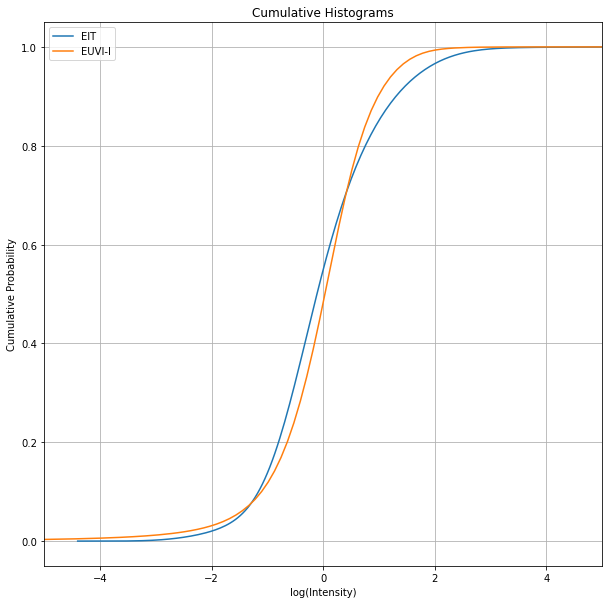

<Figure size 720x720 with 0 Axes>

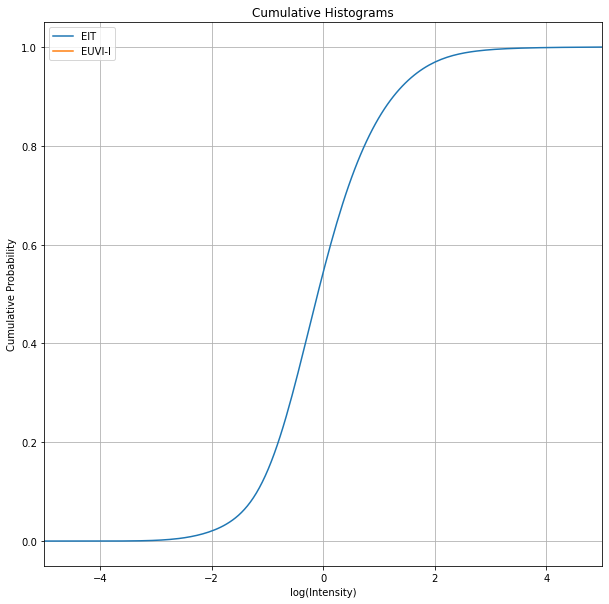

<Figure size 720x720 with 0 Axes>

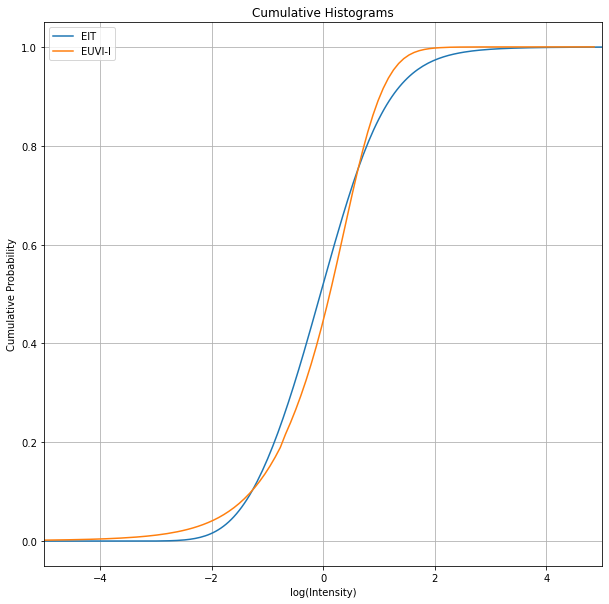

In [18]:
import matplotlib.pyplot as plt

x_euvi_195_l = bins_euvil
x_eit_195 = bins_eit

plt.figure(figsize=(10, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[0, :-1] + x_eit_195[0, 1:]) / 2
ax.plot(x, cdf_eit[0, :], c=colors[0], label='EIT')
print(np.amin(cdf_eit[0, :]), np.amax(cdf_eit[0, :]))
x = (x_euvi_195_l[0, :-1] + x_euvi_195_l[0, 1:]) / 2
ax.plot(x, cdf_euvil[0, :], c=colors[1], label='EUVI-l')
print(np.amin(cdf_euvil[0, :]), np.amax(cdf_euvil[0, :]))
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

plt.figure(figsize=(10, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[1, :-1] + x_eit_195[1, 1:]) / 2
ax.plot(x, cdf_eit[1, :], c=colors[0], label='EIT')
print(np.amin(cdf_eit[1, :]), np.amax(cdf_eit[1, :]))
x = (x_euvi_195_l[1, :-1] + x_euvi_195_l[1, 1:]) / 2
ax.plot(x, cdf_euvil[1, :], c=colors[1], label='EUVI-l')
print(np.amin(cdf_euvil[1, :]), np.amax(cdf_euvil[1, :]))
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

plt.figure(figsize=(10, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[2, :-1] + x_eit_195[2, 1:]) / 2
ax.plot(x, cdf_eit[2, :], c=colors[0], label='EIT')
x = (x_euvi_195_l[2, :-1] + x_euvi_195_l[2, 1:]) / 2
ax.plot(x, cdf_euvil[2, :], c=colors[1], label='EUVI-l')
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()

<Figure size 720x720 with 0 Axes>

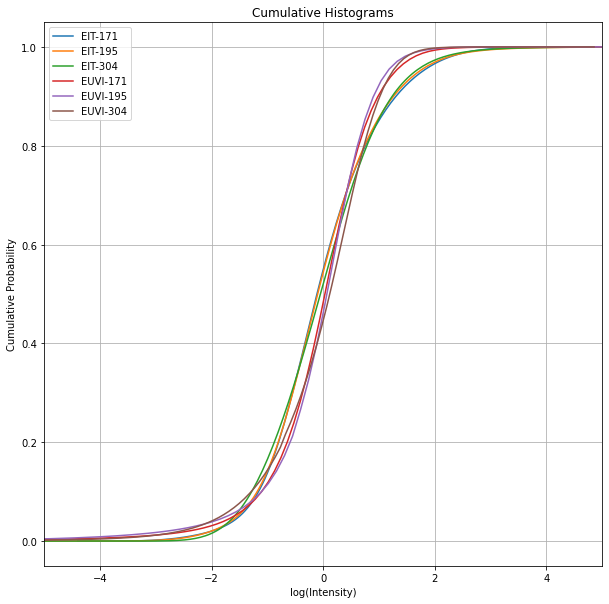

In [29]:
import matplotlib.pyplot as plt

x_euvi_195_l = bins_euvil
x_eit_195 = bins_eit

plt.figure(figsize=(10, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
fig, ax = plt.subplots(figsize=(10, 10))
x = (x_eit_195[0, :-1] + x_eit_195[0, 1:]) / 2
ax.plot(x, cdf_eit[0, :], c=colors[0], label='EIT-171')
x = (x_eit_195[1, :-1] + x_eit_195[1, 1:]) / 2
ax.plot(x, cdf_eit[1, :], c=colors[1], label='EIT-195')
x = (x_eit_195[2, :-1] + x_eit_195[2, 1:]) / 2
ax.plot(x, cdf_eit[2, :], c=colors[2], label='EIT-304')
x = (x_euvi_195_l[0, :-1] + x_euvi_195_l[0, 1:]) / 2
ax.plot(x, cdf_euvil[0, :], c=colors[3], label='EUVI-171')
x = (x_euvi_195_l[1, :-1] + x_euvi_195_l[1, 1:]) / 2
ax.plot(x, cdf_euvil[1, :], c=colors[4], label='EUVI-195')
x = (x_euvi_195_l[2, :-1] + x_euvi_195_l[2, 1:]) / 2
ax.plot(x, cdf_euvil[2, :], c=colors[5], label='EUVI-304')
ax.grid(True)
ax.set_xlim(-5., 5.)
ax.set_title('Cumulative Histograms')
ax.set_xlabel('log(Intensity)')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='best', numpoints=1)
plt.draw()